In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../WNTR_Model/')
from testWN import testWN as twm

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = (10,6)

# Data Preprocessing:

In [4]:
file = 'surrModel_TrainingDB_inp.pkl'
with open(file, 'rb') as f:
    training_in = pickle.load(f)
    
file = 'surrModel_TrainingDB_out.pkl'
with open(file, 'rb') as f:
    training_out = pickle.load(f)

In [5]:
input_names = {}
input_names_raw = training_in.keys().to_list()

output_names = {}
output_names_raw = training_out.keys().to_list()

input_names['demand'] = [name_i for name_i in input_names_raw if name_i.startswith('J')]
input_names['pumps'] = [name_i for name_i in input_names_raw if name_i.startswith('PU')]
input_names['valves'] = [name_i for name_i in input_names_raw if name_i.startswith('V')]
input_names['tanks'] = [name_i for name_i in input_names_raw if name_i.startswith('T')]

output_names['pressure'] = [name_i for name_i in output_names_raw if name_i.startswith('J')]
output_names['tanks'] = [name_i for name_i in output_names_raw if name_i.startswith('T')]
output_names['power'] = [name_i for name_i in output_names_raw if name_i.startswith('PU')]

## Check Data and filter

``data_filter`` holds a ``bool`` for every entry of the data matrices. It is set to zero if any of the conditions are not satisfied. All data is filtered in the end to exclude faulty values.

In [6]:
data_filter = np.ones(training_in.shape[0], dtype=bool)

### Junctions:
Pressure and demand.

In [7]:
junction_demand = training_in[input_names['demand']]
junction_pressure = training_out[output_names['pressure']]

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

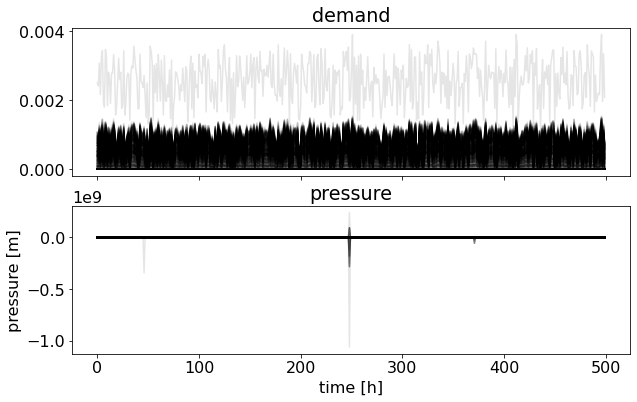

In [8]:
fig, ax = plt.subplots(2,1, sharex=True)
junction_demand.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='demand', xlabel='time [h]')
junction_pressure.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

In [9]:
data_filter = data_filter & np.all(np.abs(junction_pressure)<1e3, axis=1)
data_filter = data_filter & np.all(junction_pressure>0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pressure'}, xlabel='time [h]', ylabel='pressure [m]'>

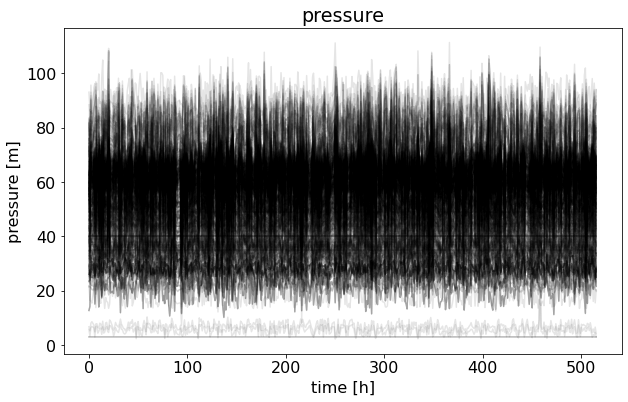

In [10]:
junction_pressure[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pressure', xlabel='time [h]', ylabel='pressure [m]')

### Tank levels:

<AxesSubplot:title={'center':'delta tank levels'}, xlabel='time [h]', ylabel='delta height [m]'>

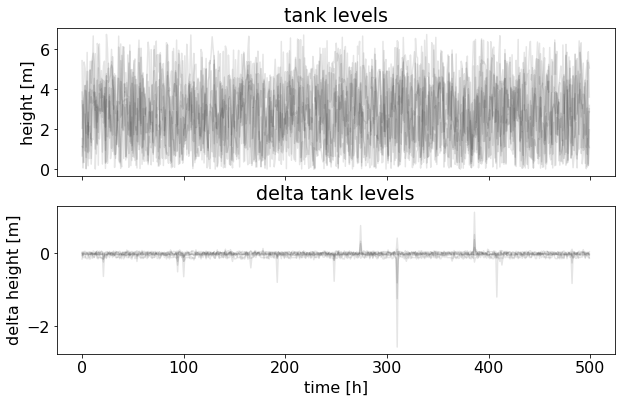

In [11]:
fig, ax = plt.subplots(2,1, sharex = True)
tank_level = training_in[input_names['tanks']]
dtank_level = training_out[output_names['tanks']]
tank_level.head(500).plot(ax=ax[0],legend=False, color='k', alpha=0.1, title='tank levels', xlabel='time [h]', ylabel='height [m]')
dtank_level.head(500).plot(ax=ax[1],legend=False, color='k', alpha=0.1, title='delta tank levels', xlabel='time [h]', ylabel='delta height [m]')

Here is something weird:
Why are the dtank_levels on average so small?

In [12]:
dtank_level.abs().mean()

T3_change    0.030501
T1_change    0.030572
T7_change    0.076700
T6_change    0.021625
T5_change    0.037384
T2_change    0.037860
T4_change    0.077307
dtype: float64

In [13]:
tank_level.diff(axis=0).abs().mean()

T3    2.252196
T1    2.175926
T7    1.667837
T6    1.839106
T5    1.502024
T2    1.963966
T4    1.574871
dtype: float64

### Pumps:

<AxesSubplot:title={'center':'pump setting'}, xlabel='time [h]', ylabel='setting'>

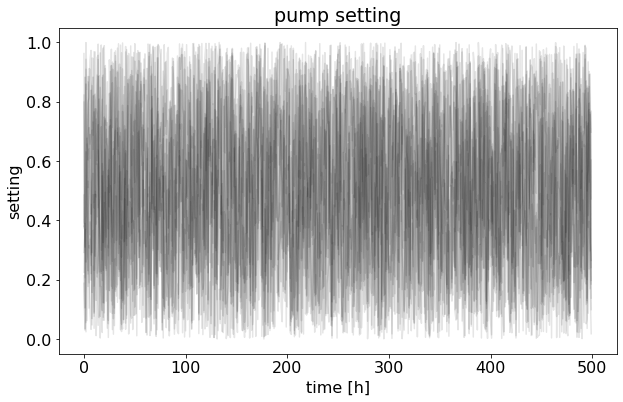

In [14]:
pump_setting = training_in[input_names['pumps']]
pump_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='pump setting', xlabel='time [h]', ylabel='setting')

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

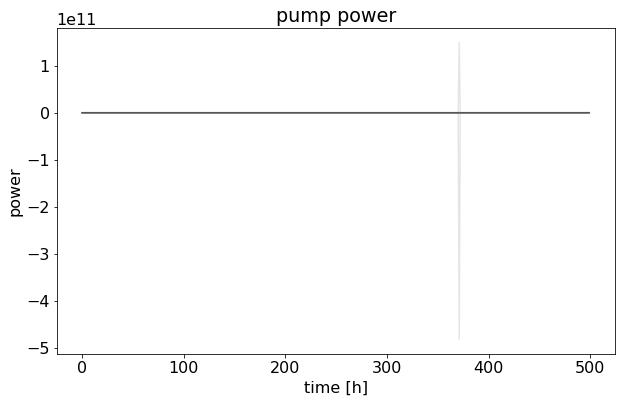

In [15]:
pump_power = training_out[output_names['power']]
pump_power.head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

In [16]:
data_filter = data_filter & np.all(np.abs(pump_power)<1e6,axis=1) & np.all(pump_power>=0, axis=1)

After filtering:

<AxesSubplot:title={'center':'pump power'}, xlabel='time [h]', ylabel='power'>

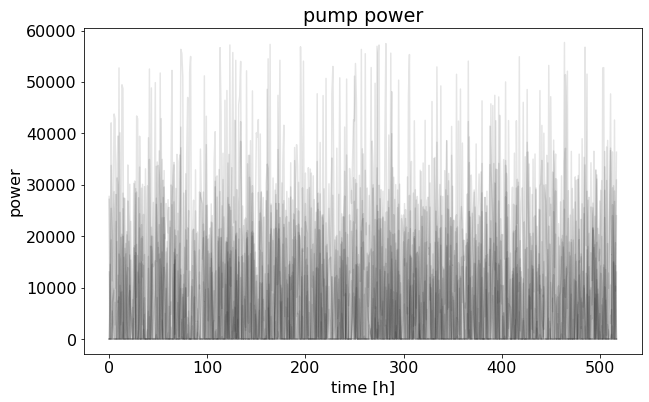

In [17]:
pump_power[data_filter].head(500).plot(legend=False, color='k', alpha=0.1, title='pump power', xlabel='time [h]', ylabel='power')

Let's check the pump_power vs pump_setting after filtering:

Text(0.5, 1.0, 'pump setting vs. power consumption')

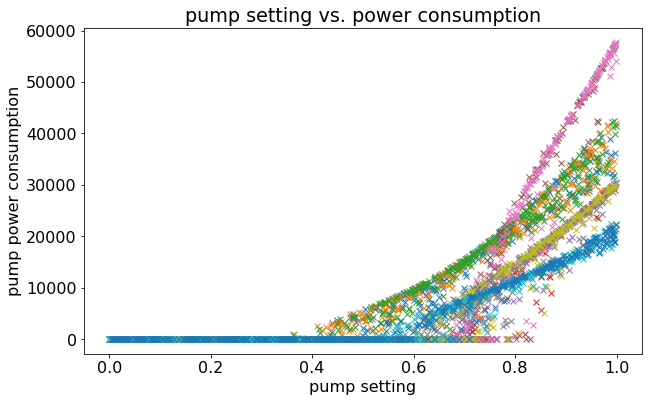

In [18]:
fig, ax = plt.subplots()
ax.plot(pump_setting[data_filter].head(500).to_numpy(), pump_power[data_filter].head(500).to_numpy(), 'x')
ax.set_xlabel('pump setting')
ax.set_ylabel('pump power consumption')
ax.set_title('pump setting vs. power consumption')

### Valves

<AxesSubplot:title={'center':'valve settting'}, xlabel='time [h]', ylabel='setting'>

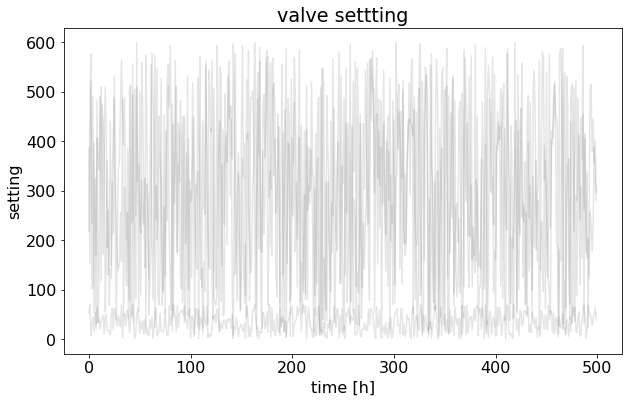

In [19]:
valve_setting = training_in[input_names['valves']]

valve_setting.head(500).plot(legend=False, color='k', alpha=0.1, title='valve settting', xlabel='time [h]', ylabel='setting')

## Neural Network Pre-Processing
### NN inputs:

In [20]:
input_1_dict = {
    'junction_demand': junction_demand[data_filter]
}
nn_inputs_1 = pd.concat(input_1_dict.values(), axis=1, keys=input_1_dict.keys())

input_2_dict = {
    'tank_level': tank_level[data_filter],
}
nn_inputs_2 = pd.concat(input_2_dict.values(), axis=1, keys=input_2_dict.keys())

input_3_dict = {
    'pump_setting': pump_setting[data_filter],                   
    'valve_setting': valve_setting[data_filter]
}
nn_inputs_3 = pd.concat(input_3_dict.values(), axis=1, keys=input_3_dict.keys())

nn_input_dict = {
    'demand': nn_inputs_1,
    'states': nn_inputs_2,
    'inputs': nn_inputs_3,
}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

nn_input.head(2)

demand                                                            \
  junction_demand                                                             
           J511_d    J411_d    J414_d J415_d J416_d    J417_d J418_d J419_d   
0        0.000700  0.000580  0.000630      0      0  0.000842      0      0   
1        0.000675  0.000487  0.000529      0      0  0.000707      0      0   

                       ...       inputs                                \
                       ... pump_setting                                 
     J310_d    J311_d  ...          PU5       PU6       PU7       PU8   
0  0.000792  0.000690  ...     0.485164  0.224395  0.822356  0.292111   
1  0.000794  0.000691  ...     0.309680  0.370562  0.104421  0.373534   

                                                                      
                                valve_setting                         
        PU9      PU10      PU11           V45         V47         V2  
0  0.962488  0.391641  0.379743    386.238187  217.183124  52.422623  
1  0.206419  0.882879  0.389592    152.092313  498.637921  69.879865  

[2 rows x 409 columns]

In [21]:
testdf =  pd.DataFrame({'a':np.array([1,5,4,1000,2,0])})
testdf

,a
0,1
1,5
2,4
3,1000
4,2
5,0


In [22]:
testdf_filter = testdf < 10
testdf[testdf_filter].diff().shift(-1)

,a
0,4.0
1,-1.0
2,NaN
3,NaN
4,-2.0
5,NaN


### NN outputs:

In [23]:
dtank_level = tank_level[data_filter].diff(axis=0)
dtank_level_next = dtank_level.shift(-1, axis=0)
#tank_level_next = dtank_level

output_1_dict ={
    'junction_pressure': junction_pressure[data_filter],
}
nn_outputs_1 = pd.concat(output_1_dict.values(), axis=1, keys=output_1_dict.keys())

output_2_dict = {
    'pump_power': pump_power[data_filter],
}
nn_outputs_2 = pd.concat(output_2_dict.values(), axis=1, keys=output_2_dict.keys())

output_3_dict = {
    'dtank_level_next': dtank_level_next,
}
nn_outputs_3 = pd.concat(output_3_dict.values(), axis=1, keys=output_3_dict.keys())

nn_output_dict = {
    'pressure': nn_outputs_1,
    'energy': nn_outputs_2,
    'dstates': nn_outputs_3,
}
nn_output = pd.concat(nn_output_dict.values(), axis=1, keys=nn_output_dict.keys())

nn_output.head(2)

pressure                                                         \
  junction_pressure                                                          
             J511_p     J411_p     J414_p     J415_p     J416_p     J417_p   
0         29.335041  59.942562  32.781395  73.341827  93.096062  29.215940   
1         29.661058  60.530811  33.863552  63.839569  86.239571  30.458761   

                                               ...        energy               \
                                               ...    pump_power                
      J418_p     J419_p     J310_p     J311_p  ...         PU9_P       PU10_P   
0  28.945457  25.694481  49.679050  45.589382  ...  27162.515625      0.00000   
1  30.266699  26.694220  50.819473  46.729816  ...      0.000000  14526.26304   

                  dstates                                                    \
         dtank_level_next                                                     
  PU11_P               T3        T1        T7        T6        T5        T2   
0    0.0        -1.477721 -4.318732 -3.531051  1.228210 -1.455486 -0.075266   
1    0.0         3.213431  2.266550  3.273092  3.468011 -0.712197 -0.716430   

             
             
         T4  
0  1.181930  
1 -0.329851  

[2 rows x 406 columns]

In [24]:
nn_output['dstates'].abs().max()

dtank_level_next  T3    6.737185
                  T1    6.488187
                  T7    4.965417
                  T6    5.495135
                  T5    4.484990
                  T2    5.884032
                  T4    4.668671
dtype: float64

In [25]:
nn_input['states'].max()

tank_level  T3    6.749925
            T1    6.499984
            T7    4.999986
            T6    5.499979
            T5    4.499951
            T2    5.899931
            T4    4.699888
dtype: float64

Filter inputs and outputs. Due to shifting, we introduced `NaN` in the dataframes. These are removed in this step.

In [26]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]
    

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples={}, n_inputs = {}, n_outputs={}'.format(*nn_input.shape, nn_output.shape[1]))

n_samples=96578, n_inputs = 409, n_outputs=406


In [27]:
input_scaling = nn_input.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input/input_scaling

output_scaling = nn_output.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output/output_scaling

# DNN Model creation

Create model architecture with input to condense the demand and then input for states control inputs etc.

In [28]:
UnitNorm_cons = tf.keras.constraints.UnitNorm(axis=1)
minmax_cons = tf.keras.constraints.MinMaxNorm(
    min_value=0, max_value=1.0, rate=1.0, axis=1
)
nonneg_cons = tf.keras.constraints.NonNeg()
#nonnegunit_cons =  nonnegUnitNorm(axis=1)

l1_penalty = tf.keras.regularizers.l1(l=0.001)
l2_penalty = tf.keras.regularizers.l2(l=0.1)

In [80]:
n_cluster = 30
n_layer = 4
n_neurons_per_layer = 100

# Input 1 with reduction:
tf_in_1 = tf.keras.Input(shape=(nn_input['demand'].shape[1]), name='demand_in')
tf_in_1_red = tf.keras.layers.Dense(
    n_cluster, 
    name='cluster_demand', 
    use_bias=False,
    #activation=tf.nn.tanh,
    #kernel_regularizer=l1_penalty,
    #kernel_constraint=UnitNorm_cons,
)(tf_in_1)

# Input 2 & 3
tf_in_2 = tf.keras.Input(shape=(nn_input['states'].shape[1],), name='states_in')
tf_in_3 = tf.keras.Input(shape=(nn_input['inputs'].shape[1],), name='inputs_in')

# Concatenating inputs:
tf_in_cat = tf.keras.layers.concatenate([tf_in_1_red, tf_in_2, tf_in_3], name='input_concatenate')

# Intermediate (non-linear) layers:
for i in range(n_layer):
    if i == 0:
        tf_interm = tf.keras.layers.Dense(n_neurons_per_layer, activation=tf.nn.relu, name='interm_'+str(i))(tf_in_cat)
    else:
        tf_interm = tf.keras.layers.Dense(n_neurons_per_layer, activation=tf.nn.relu, name='interm_'+str(i))(tf_interm)

# splitting:
tf_interm_1 = tf_interm[:,:n_cluster]
tf_interm_2 = tf_interm[:,n_cluster:]

# Linear output layer
tf_out_1 = tf.keras.layers.Dense(
    nn_output['pressure'].shape[1], 
    name='pressure_out', 
    use_bias=False,
    #kernel_constraint=nonneg_cons,
    #kernel_regularizer = l1_penalty,
)(tf_interm_1)

tf_out_2 = tf.keras.layers.Dense(nn_output['energy'].shape[1], name='energy_out')(tf_interm_2)
tf_out_3 = tf.keras.layers.Dense(nn_output['dstates'].shape[1], name='dstates_out')(tf_interm_2)


In [81]:
model = tf.keras.Model(inputs=[tf_in_1, tf_in_2, tf_in_3], outputs=[tf_out_1,tf_out_2, tf_out_3])

In [82]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim, loss='mse')

## Model training

In [83]:

history = model.fit([nn_input_scaled['demand'], nn_input_scaled['states'], nn_input_scaled['inputs']], 
                    [nn_output_scaled['pressure'], nn_output_scaled['energy'], nn_output_scaled['dstates']], 
                    batch_size=10000, 
                    epochs=1000)

Epoch 1/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.7256 - pressure_out_loss: 0.4394 - energy_out_loss: 0.1135 - dstates_out_loss: 0.1727
Epoch 2/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.5660 - pressure_out_loss: 0.3187 - energy_out_loss: 0.0856 - dstates_out_loss: 0.1617
Epoch 3/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.3779 - pressure_out_loss: 0.1500 - energy_out_loss: 0.0754 - dstates_out_loss: 0.1525
Epoch 4/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.2678 - pressure_out_loss: 0.0547 - energy_out_loss: 0.0706 - dstates_out_loss: 0.1425
Epoch 5/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.2194 - pressure_out_loss: 0.0199 - energy_out_loss: 0.0671 - dstates_out_loss: 0.1324
Epoch 6/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.1968 - pressure_out_loss: 0.0101 - energy_out_loss: 0.0637 - dstates_out_loss: 0.1230
Epoch 7/1000
10/10 [==

10/10 [==============================] - 1s 65ms/step - loss: 0.1075 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0220 - dstates_out_loss: 0.0839
Epoch 52/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.1074 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0216 - dstates_out_loss: 0.0842
Epoch 53/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.1071 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0211 - dstates_out_loss: 0.0843
Epoch 54/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.1067 - pressure_out_loss: 0.0017 - energy_out_loss: 0.0207 - dstates_out_loss: 0.0843
Epoch 55/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.1061 - pressure_out_loss: 0.0016 - energy_out_loss: 0.0205 - dstates_out_loss: 0.0840
Epoch 56/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.1054 - pressure_out_loss: 0.0015 - energy_out_loss: 0.0200 - dstates_out_loss: 0.0839
Epoch 57/1000
10/10 [=========

10/10 [==============================] - 1s 67ms/step - loss: 0.0924 - pressure_out_loss: 9.8321e-04 - energy_out_loss: 0.0076 - dstates_out_loss: 0.0838
Epoch 101/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0922 - pressure_out_loss: 9.4699e-04 - energy_out_loss: 0.0073 - dstates_out_loss: 0.0839
Epoch 102/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0915 - pressure_out_loss: 8.9650e-04 - energy_out_loss: 0.0067 - dstates_out_loss: 0.0838
Epoch 103/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0910 - pressure_out_loss: 8.8133e-04 - energy_out_loss: 0.0063 - dstates_out_loss: 0.0838
Epoch 104/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0906 - pressure_out_loss: 8.7238e-04 - energy_out_loss: 0.0061 - dstates_out_loss: 0.0836
Epoch 105/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0905 - pressure_out_loss: 8.8149e-04 - energy_out_loss: 0.0060 - dstates_out_loss: 0.0837
E

10/10 [==============================] - 1s 65ms/step - loss: 0.0869 - pressure_out_loss: 6.1423e-04 - energy_out_loss: 0.0027 - dstates_out_loss: 0.0836
Epoch 149/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0867 - pressure_out_loss: 5.9973e-04 - energy_out_loss: 0.0026 - dstates_out_loss: 0.0835
Epoch 150/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0866 - pressure_out_loss: 5.9417e-04 - energy_out_loss: 0.0025 - dstates_out_loss: 0.0835
Epoch 151/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0867 - pressure_out_loss: 6.0040e-04 - energy_out_loss: 0.0026 - dstates_out_loss: 0.0836
Epoch 152/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0865 - pressure_out_loss: 5.8793e-04 - energy_out_loss: 0.0024 - dstates_out_loss: 0.0835
Epoch 153/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0864 - pressure_out_loss: 5.7837e-04 - energy_out_loss: 0.0023 - dstates_out_loss: 0.0835
E

10/10 [==============================] - 1s 66ms/step - loss: 0.0858 - pressure_out_loss: 4.0339e-04 - energy_out_loss: 0.0019 - dstates_out_loss: 0.0835
Epoch 197/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0860 - pressure_out_loss: 4.0413e-04 - energy_out_loss: 0.0020 - dstates_out_loss: 0.0836
Epoch 198/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0860 - pressure_out_loss: 4.1329e-04 - energy_out_loss: 0.0020 - dstates_out_loss: 0.0836
Epoch 199/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0857 - pressure_out_loss: 3.9259e-04 - energy_out_loss: 0.0018 - dstates_out_loss: 0.0835
Epoch 200/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0857 - pressure_out_loss: 3.9326e-04 - energy_out_loss: 0.0019 - dstates_out_loss: 0.0835
Epoch 201/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0858 - pressure_out_loss: 3.8720e-04 - energy_out_loss: 0.0019 - dstates_out_loss: 0.0835
E

10/10 [==============================] - 1s 67ms/step - loss: 0.0855 - pressure_out_loss: 2.9315e-04 - energy_out_loss: 0.0017 - dstates_out_loss: 0.0835
Epoch 245/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0855 - pressure_out_loss: 2.9662e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0835
Epoch 246/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0854 - pressure_out_loss: 2.8918e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0835
Epoch 247/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0854 - pressure_out_loss: 2.8309e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0835
Epoch 248/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0857 - pressure_out_loss: 2.9247e-04 - energy_out_loss: 0.0018 - dstates_out_loss: 0.0836
Epoch 249/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0856 - pressure_out_loss: 3.0279e-04 - energy_out_loss: 0.0018 - dstates_out_loss: 0.0836
E

10/10 [==============================] - 1s 68ms/step - loss: 0.0853 - pressure_out_loss: 2.4577e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0835
Epoch 293/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0853 - pressure_out_loss: 2.6318e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0834
Epoch 294/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0854 - pressure_out_loss: 2.4825e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0835
Epoch 295/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0854 - pressure_out_loss: 2.5253e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0835
Epoch 296/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0853 - pressure_out_loss: 2.6051e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0835
Epoch 297/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0853 - pressure_out_loss: 2.4392e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0835
E

10/10 [==============================] - 1s 67ms/step - loss: 0.0850 - pressure_out_loss: 2.2598e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 341/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0851 - pressure_out_loss: 2.2680e-04 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0833
Epoch 342/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0852 - pressure_out_loss: 2.2666e-04 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0834
Epoch 343/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0852 - pressure_out_loss: 2.2591e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0834
Epoch 344/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0853 - pressure_out_loss: 2.3187e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0835
Epoch 345/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0853 - pressure_out_loss: 2.4447e-04 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0835
E

10/10 [==============================] - 1s 67ms/step - loss: 0.0849 - pressure_out_loss: 2.1244e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0834
Epoch 389/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0850 - pressure_out_loss: 2.2010e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 390/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0851 - pressure_out_loss: 2.1811e-04 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0834
Epoch 391/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0852 - pressure_out_loss: 2.3053e-04 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0834
Epoch 392/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0852 - pressure_out_loss: 2.2344e-04 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0835
Epoch 393/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0852 - pressure_out_loss: 2.1960e-04 - energy_out_loss: 0.0016 - dstates_out_loss: 0.0834
E

10/10 [==============================] - 1s 66ms/step - loss: 0.0850 - pressure_out_loss: 2.1561e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 437/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0850 - pressure_out_loss: 2.0538e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 438/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0850 - pressure_out_loss: 2.2918e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0834
Epoch 439/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0849 - pressure_out_loss: 1.9418e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 440/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0850 - pressure_out_loss: 2.1398e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 441/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0849 - pressure_out_loss: 2.1938e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
E

10/10 [==============================] - 1s 67ms/step - loss: 0.0850 - pressure_out_loss: 1.8996e-04 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0834
Epoch 485/1000
10/10 [==============================] - 1s 68ms/step - loss: 0.0848 - pressure_out_loss: 1.7910e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0833
Epoch 486/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0850 - pressure_out_loss: 1.9840e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 487/1000
10/10 [==============================] - 1s 69ms/step - loss: 0.0849 - pressure_out_loss: 1.9576e-04 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0833
Epoch 488/1000
10/10 [==============================] - 1s 69ms/step - loss: 0.0849 - pressure_out_loss: 1.8667e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 489/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0849 - pressure_out_loss: 1.9409e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
E

10/10 [==============================] - 1s 71ms/step - loss: 0.0848 - pressure_out_loss: 1.7231e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 533/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0848 - pressure_out_loss: 1.9313e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0833
Epoch 534/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0849 - pressure_out_loss: 1.7512e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0834
Epoch 535/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0850 - pressure_out_loss: 1.9072e-04 - energy_out_loss: 0.0015 - dstates_out_loss: 0.0833
Epoch 536/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0848 - pressure_out_loss: 1.7738e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0832
Epoch 537/1000
10/10 [==============================] - 1s 71ms/step - loss: 0.0849 - pressure_out_loss: 1.7841e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0833
E

10/10 [==============================] - 1s 70ms/step - loss: 0.0848 - pressure_out_loss: 1.7627e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
Epoch 581/1000
10/10 [==============================] - 1s 69ms/step - loss: 0.0848 - pressure_out_loss: 1.7978e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 582/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0849 - pressure_out_loss: 1.6975e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 583/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0848 - pressure_out_loss: 1.9286e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 584/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0848 - pressure_out_loss: 1.8825e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 585/1000
10/10 [==============================] - 1s 72ms/step - loss: 0.0847 - pressure_out_loss: 1.6348e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
E

10/10 [==============================] - 1s 71ms/step - loss: 0.0847 - pressure_out_loss: 1.7542e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
Epoch 629/1000
10/10 [==============================] - 1s 71ms/step - loss: 0.0847 - pressure_out_loss: 1.6493e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
Epoch 630/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0847 - pressure_out_loss: 1.5518e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
Epoch 631/1000
10/10 [==============================] - 1s 70ms/step - loss: 0.0848 - pressure_out_loss: 1.5720e-04 - energy_out_loss: 0.0014 - dstates_out_loss: 0.0833
Epoch 632/1000
10/10 [==============================] - 1s 68ms/step - loss: 0.0847 - pressure_out_loss: 1.6169e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
Epoch 633/1000
10/10 [==============================] - 1s 69ms/step - loss: 0.0847 - pressure_out_loss: 1.6759e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
E

10/10 [==============================] - 1s 68ms/step - loss: 0.0845 - pressure_out_loss: 1.5800e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 677/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0846 - pressure_out_loss: 1.4993e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 678/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0846 - pressure_out_loss: 1.5502e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
Epoch 679/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0847 - pressure_out_loss: 1.7335e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0833
Epoch 680/1000
10/10 [==============================] - 1s 69ms/step - loss: 0.0848 - pressure_out_loss: 1.6452e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0833
Epoch 681/1000
10/10 [==============================] - 1s 68ms/step - loss: 0.0848 - pressure_out_loss: 1.8581e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
E

10/10 [==============================] - 1s 66ms/step - loss: 0.0845 - pressure_out_loss: 1.5203e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 725/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0846 - pressure_out_loss: 1.6462e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
Epoch 726/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0847 - pressure_out_loss: 1.7495e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
Epoch 727/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0846 - pressure_out_loss: 1.5271e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 728/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0845 - pressure_out_loss: 1.4973e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 729/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0845 - pressure_out_loss: 1.4964e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0831
E

10/10 [==============================] - 1s 68ms/step - loss: 0.0846 - pressure_out_loss: 1.6394e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0831
Epoch 773/1000
10/10 [==============================] - 1s 68ms/step - loss: 0.0846 - pressure_out_loss: 1.6151e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0832
Epoch 774/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0846 - pressure_out_loss: 1.7245e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 775/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0846 - pressure_out_loss: 1.4926e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 776/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0845 - pressure_out_loss: 1.4910e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 777/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0845 - pressure_out_loss: 1.5228e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
E

10/10 [==============================] - 1s 106ms/step - loss: 0.0844 - pressure_out_loss: 1.5326e-04 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0831
Epoch 821/1000
10/10 [==============================] - 1s 69ms/step - loss: 0.0846 - pressure_out_loss: 1.5340e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832 0s - loss: 0.0846 - pressure_out_loss: 1.5340e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.08
Epoch 822/1000
10/10 [==============================] - 1s 72ms/step - loss: 0.0847 - pressure_out_loss: 1.8049e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0833
Epoch 823/1000
10/10 [==============================] - 1s 67ms/step - loss: 0.0847 - pressure_out_loss: 1.6263e-04 - energy_out_loss: 0.0013 - dstates_out_loss: 0.0833
Epoch 824/1000
10/10 [==============================] - 1s 66ms/step - loss: 0.0847 - pressure_out_loss: 1.6143e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0833
Epoch 825/1000
10/10 [==============================] - 1s 63ms/step

10/10 [==============================] - 1s 64ms/step - loss: 0.0846 - pressure_out_loss: 1.4534e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 868/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.0844 - pressure_out_loss: 1.4970e-04 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0832
Epoch 869/1000
10/10 [==============================] - 1s 63ms/step - loss: 0.0844 - pressure_out_loss: 1.5467e-04 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0831
Epoch 870/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.0844 - pressure_out_loss: 1.4436e-04 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0831
Epoch 871/1000
10/10 [==============================] - 1s 65ms/step - loss: 0.0845 - pressure_out_loss: 1.6306e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0831
Epoch 872/1000
10/10 [==============================] - 1s 64ms/step - loss: 0.0844 - pressure_out_loss: 1.5013e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0831
E

10/10 [==============================] - 2s 182ms/step - loss: 0.0844 - pressure_out_loss: 1.4397e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0831
Epoch 916/1000
10/10 [==============================] - 2s 181ms/step - loss: 0.0844 - pressure_out_loss: 1.4841e-04 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0831
Epoch 917/1000
10/10 [==============================] - 2s 182ms/step - loss: 0.0844 - pressure_out_loss: 1.4416e-04 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0831
Epoch 918/1000
10/10 [==============================] - 2s 186ms/step - loss: 0.0844 - pressure_out_loss: 1.5419e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0831
Epoch 919/1000
10/10 [==============================] - 2s 187ms/step - loss: 0.0844 - pressure_out_loss: 1.4925e-04 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0831
Epoch 920/1000
10/10 [==============================] - 2s 188ms/step - loss: 0.0845 - pressure_out_loss: 1.5828e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.

10/10 [==============================] - 2s 184ms/step - loss: 0.0845 - pressure_out_loss: 1.4765e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0831
Epoch 964/1000
10/10 [==============================] - 2s 184ms/step - loss: 0.0844 - pressure_out_loss: 1.5309e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0831
Epoch 965/1000
10/10 [==============================] - 2s 188ms/step - loss: 0.0844 - pressure_out_loss: 1.6210e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0831
Epoch 966/1000
10/10 [==============================] - 2s 190ms/step - loss: 0.0844 - pressure_out_loss: 1.4553e-04 - energy_out_loss: 0.0011 - dstates_out_loss: 0.0831
Epoch 967/1000
10/10 [==============================] - 2s 195ms/step - loss: 0.0845 - pressure_out_loss: 1.4824e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.0832
Epoch 968/1000
10/10 [==============================] - 212s 21s/step - loss: 0.0845 - pressure_out_loss: 1.4511e-04 - energy_out_loss: 0.0012 - dstates_out_loss: 0.

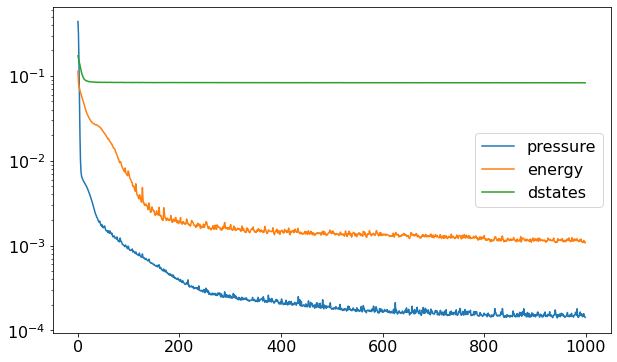

In [84]:
plt.semilogy(history.epoch,history.history['pressure_out_loss'], label='pressure')
plt.semilogy(history.epoch,history.history['energy_out_loss'], label='energy')
plt.semilogy(history.epoch,history.history['dstates_out_loss'], label='dstates')
plt.legend()

In [39]:
A_cluster = model.get_layer('cluster_demand').get_weights()[0]

### Simulation evaluation

In [85]:
from IPython.display import clear_output, display

In [86]:
N = 200

demand = nn_input['demand'].head(N).to_numpy()
states = nn_input['states'].head(N).to_numpy()
inputs = nn_input['inputs'].head(N).to_numpy()

in_d_scaling = input_scaling['demand'].to_numpy()
in_s_scaling = input_scaling['states'].to_numpy()
in_i_scaling = input_scaling['inputs'].to_numpy()

pressure = nn_output['pressure'].head(N).to_numpy()
energy = nn_output['energy'].head(N).to_numpy()

out_p_scaling = output_scaling['pressure'].to_numpy()
out_e_scaling = output_scaling['energy'].to_numpy()
out_s_scaling = output_scaling['dstates'].to_numpy()

In [87]:
for k in range(N-1):
    clear_output(wait=True)
    print(k)
    demand_k = demand[[k],:]
    states_k = states[[k],:]
    inputs_k = inputs[[k],:]
    
    demand_k_scaled = demand_k/in_d_scaling
    states_k_scaled = states_k/in_s_scaling
    inputs_k_scaled = inputs_k/in_i_scaling

    pressure_scaled, energy_scaled, dstates_scaled = model.predict([demand_k_scaled, states_k_scaled, inputs_k_scaled])
    
    pressure_k = pressure_scaled * out_p_scaling
    energy_k = energy_scaled * out_e_scaling
    states_k_next = states_k + dstates_scaled * out_s_scaling
    
    energy[[k],:] = energy_k
    pressure[[k],:] = pressure_k
    states[[k+1],:] = states_k_next

198


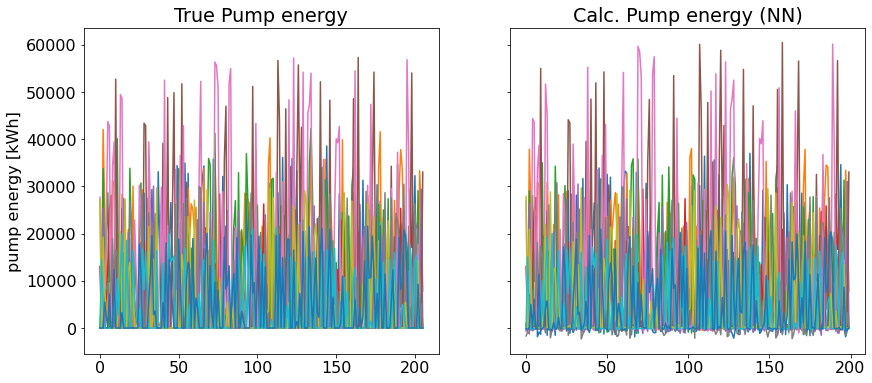

In [88]:
fig,ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
pump_power[data_filter].head(N).plot(legend=False, ax=ax[0])
ax[1].plot(energy)
ax[0].set_title('True Pump energy')
ax[1].set_title('Calc. Pump energy (NN)')
ax[0].set_ylabel('pump energy [kWh]')
plt.show()

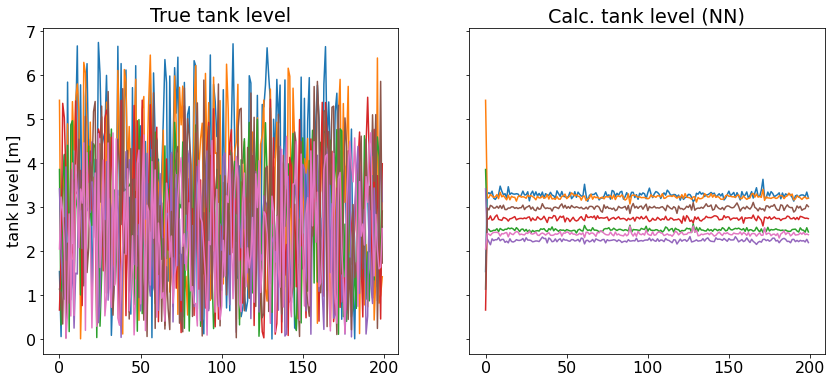

In [89]:
fig,ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
tank_level.head(N).plot(legend=False, ax=ax[0])
ax[1].plot(states)
ax[0].set_title('True tank level')
ax[1].set_title('Calc. tank level (NN)')
ax[0].set_ylabel('tank level [m]')
plt.show()

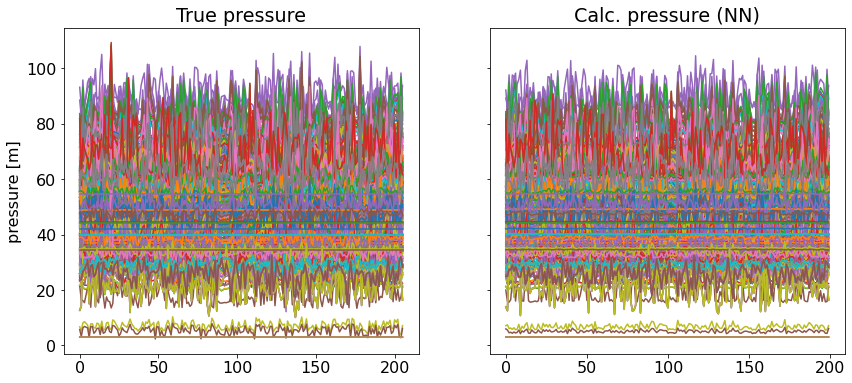

In [90]:
fig,ax = plt.subplots(1,2, figsize=(14,6), sharey=True)
junction_pressure[data_filter].head(N).plot(legend=False, ax=ax[0])
ax[1].plot(pressure)
ax[0].set_title('True pressure')
ax[1].set_title('Calc. pressure (NN)')
ax[0].set_ylabel('pressure [m]')
plt.show()

/Users/felixfiedler/opt/miniconda3/envs/py36WaGa/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


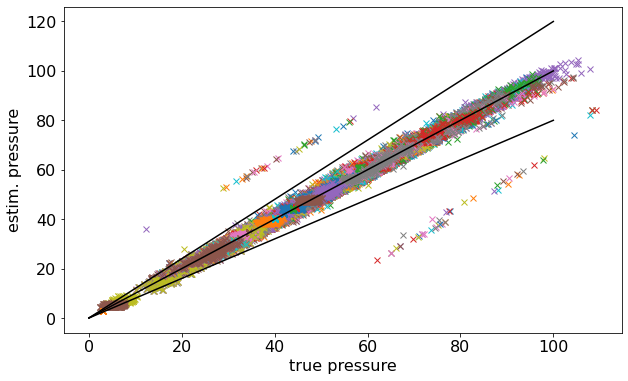

In [91]:
fig, ax = plt.subplots()

ax.plot(junction_pressure[data_filter].head(N), pressure,'x')
ax.plot([0,100],[0,100],'k')
ax.plot([0,100],[0,120],'k')
ax.plot([0,100],[0,80],'k')
ax.set_xlabel('true pressure')
ax.set_ylabel('estim. pressure')

fig.show()